# Import libraries

In [1]:
import pandas as pd
pd.options.mode.chained_assignment = None #Ignore pandas warning

import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from datasist.structdata import detect_outliers 

from sklearn.preprocessing import OneHotEncoder


# Data exploring

In [3]:
url = "https://raw.githubusercontent.com/sinhvienfpt/UsedCarPricePrediction/main/assets/data/train-data.csv"

In [4]:
df = pd.read_csv(url,index_col=0)
df.head()

,Name,Location,Year,Kilometers_Driven,Fuel_Type,Transmission,Owner_Type,Mileage,Engine,Power,Seats,New_Price,Price
0,Maruti Wagon R LXI CNG,Mumbai,2010,72000,CNG,Manual,First,26.6 km/kg,998 CC,58.16 bhp,5.0,NaN,1.75
1,Hyundai Creta 1.6 CRDi SX Option,Pune,2015,41000,Diesel,Manual,First,19.67 kmpl,1582 CC,126.2 bhp,5.0,NaN,12.50
2,Honda Jazz V,Chennai,2011,46000,Petrol,Manual,First,18.2 kmpl,1199 CC,88.7 bhp,5.0,8.61 Lakh,4.50
3,Maruti Ertiga VDI,Chennai,2012,87000,Diesel,Manual,First,20.77 kmpl,1248 CC,88.76 bhp,7.0,NaN,6.00
4,Audi A4 New 2.0 TDI Multitronic,Coimbatore,2013,40670,Diesel,Automatic,Second,15.2 kmpl,1968 CC,140.8 bhp,5.0,NaN,17.74


In [29]:
print(df.shape)

(6019, 13)


## Data Cleaning

Make a new column name `brand` from the column `name` by taking the first word.

In [30]:
df["Brand"] = df["Name"].apply(lambda x : x.split()[0])

### Null value

In [31]:
df.isnull().sum()

Name                    0
Location                0
Year                    0
Kilometers_Driven       0
Fuel_Type               0
Transmission            0
Owner_Type              0
Mileage                 2
Engine                 36
Power                  36
Seats                  42
New_Price            5195
Price                   0
Brand                   0
dtype: int64

In [32]:
# Drop column New_Price
df = df.drop("New_Price",axis=1)

# Drop all null row
df = df.dropna(how='any')

### `Year`
Add a column `Age` calculated by subtracting the year when the data collected (2019) from the `year`

In [33]:
df["Age"] = 2019 - df["Year"]

### `Mileage`
The `Mileage` column in your data uses two different units of measurement: 'km/kg' and 'kmpl'.

In [34]:
kmkg = 0
kmpl = 0
for i in df.Mileage:
    if str(i).endswith("km/kg"):
        kmkg+=1
    elif str(i).endswith("kmpl"):
        kmpl+=1
print('The number of rows with Km/Kg : {} '.format(kmkg))
print('The number of rows with Kmpl : {} '.format(kmpl))

The number of rows with Km/Kg : 66 
The number of rows with Kmpl : 5909 


So we can see the amount of rows with Kmpl is greater than Km/Kg (nearly 90 times). So I decided to convert from Km/Kg into Kmpl. Let take a view at the fuel_type which use km/kg for Mileage.

In [35]:
kmkg_fuel_type = set()
for i in df[df.Mileage.str.endswith("km/kg")].Fuel_Type:
    kmkg_fuel_type.add(i)
print('Fuel type for km/kg : {}'.format(kmkg_fuel_type))

Fuel type for km/kg : {'CNG', 'LPG'}


`CNG` (Compressed Natural Gas) and `LPG` (Liquefied Petroleum Gas) are two types of gas fuels that use km/kg units in the data.

| Characteristic | CNG | LPG |
|----------------|-----|-----|
| Density | 0.75 - 0.83 Kg/Sm³ | 0.51 - 0.56 kg/L |
|Average Desity| 0.79 Kg/Sm³| 0.535 kg/L|

In [36]:
# Convert km/kg to kmpl
for i in range(len(df)):
    m = df.Mileage.iloc[i]
    m = str(m)
    if ' ' in m:
        m,unit = m.split(" ")
        
        if unit == "km/kg":
            if df.Fuel_Type.iloc[i] == "CNG":
                m = float(m)*0.79
            elif df.Fuel_Type.iloc[i] == "LPG":
                m = float(m)*0.535
    
    df["Mileage"].iloc[i] = round(float(m),2)

In [37]:
df.head()

,Name,Location,Year,Kilometers_Driven,Fuel_Type,Transmission,Owner_Type,Mileage,Engine,Power,Seats,Price,Brand,Age
0,Maruti Wagon R LXI CNG,Mumbai,2010,72000,CNG,Manual,First,21.01,998 CC,58.16 bhp,5.0,1.75,Maruti,9
1,Hyundai Creta 1.6 CRDi SX Option,Pune,2015,41000,Diesel,Manual,First,19.67,1582 CC,126.2 bhp,5.0,12.50,Hyundai,4
2,Honda Jazz V,Chennai,2011,46000,Petrol,Manual,First,18.2,1199 CC,88.7 bhp,5.0,4.50,Honda,8
3,Maruti Ertiga VDI,Chennai,2012,87000,Diesel,Manual,First,20.77,1248 CC,88.76 bhp,7.0,6.00,Maruti,7
4,Audi A4 New 2.0 TDI Multitronic,Coimbatore,2013,40670,Diesel,Automatic,Second,15.2,1968 CC,140.8 bhp,5.0,17.74,Audi,6


### `Engine` and `Power`

In [38]:
# Find the units of columns Power
tmp = df["Power"].str.split(" ").str[1].unique()
print(tmp)

# Find the units of columns Engine
tmp = df["Engine"].str.split(" ").str[1].unique()
print(tmp)

['bhp']
['CC']


In [39]:
# Convert them  to numeric
def safe_float(x):
    try:
        return float(x.split()[0])
    except:
        return np.nan

df["Power"] = df["Power"].apply(safe_float)
df["Engine"] = df["Engine"].apply(safe_float)

df.head()

,Name,Location,Year,Kilometers_Driven,Fuel_Type,Transmission,Owner_Type,Mileage,Engine,Power,Seats,Price,Brand,Age
0,Maruti Wagon R LXI CNG,Mumbai,2010,72000,CNG,Manual,First,21.01,998.0,58.16,5.0,1.75,Maruti,9
1,Hyundai Creta 1.6 CRDi SX Option,Pune,2015,41000,Diesel,Manual,First,19.67,1582.0,126.20,5.0,12.50,Hyundai,4
2,Honda Jazz V,Chennai,2011,46000,Petrol,Manual,First,18.2,1199.0,88.70,5.0,4.50,Honda,8
3,Maruti Ertiga VDI,Chennai,2012,87000,Diesel,Manual,First,20.77,1248.0,88.76,7.0,6.00,Maruti,7
4,Audi A4 New 2.0 TDI Multitronic,Coimbatore,2013,40670,Diesel,Automatic,Second,15.2,1968.0,140.80,5.0,17.74,Audi,6


### Category variables

Numerical Encoding `Owner_Type` column.

In [40]:
transformation = {
    "First":3,
    "Second":2,
    "Third":1,
    "Fourth & Above":0
}

In [41]:
df['Owner_Type'] = df['Owner_Type'].map(transformation)

OneHot Encoding for categorical columns.

In [42]:
_categorical = ['Location','Fuel_Type','Transmission','Brand']

# Print unique values of each categorical columns
for col in _categorical:
    print(f"{col} : {df[col].unique()}")
    print()

Location : ['Mumbai' 'Pune' 'Chennai' 'Coimbatore' 'Hyderabad' 'Jaipur' 'Kochi'
 'Kolkata' 'Delhi' 'Bangalore' 'Ahmedabad']

Fuel_Type : ['CNG' 'Diesel' 'Petrol' 'LPG']

Transmission : ['Manual' 'Automatic']

Brand : ['Maruti' 'Hyundai' 'Honda' 'Audi' 'Nissan' 'Toyota' 'Volkswagen' 'Tata'
 'Land' 'Mitsubishi' 'Renault' 'Mercedes-Benz' 'BMW' 'Mahindra' 'Ford'
 'Porsche' 'Datsun' 'Jaguar' 'Volvo' 'Chevrolet' 'Skoda' 'Mini' 'Fiat'
 'Jeep' 'Smart' 'Ambassador' 'Isuzu' 'ISUZU' 'Force' 'Bentley'
 'Lamborghini']



In [43]:
# One hot
ohe = OneHotEncoder(sparse=False)
for col in _categorical:
    ohe.fit(df[[col]])
    df[ohe.categories_[0]] = ohe.transform(df[[col]])
df.shape

c:\Users\ADMIN\anaconda3\Lib\site-packages\sklearn\preprocessing\_encoders.py:868: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(
c:\Users\ADMIN\anaconda3\Lib\site-packages\sklearn\preprocessing\_encoders.py:868: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(
c:\Users\ADMIN\anaconda3\Lib\site-packages\sklearn\preprocessing\_encoders.py:868: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(
c:\Users\ADMIN\anaconda3\Lib\site-packages\sklearn\preprocessing\_encoders.py:868: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. 

(5975, 62)

**Drop no-need columns and Outliners**

In [44]:
cols_to_drop = ["Year","Fuel_Type","Transmission"]
df = df.drop(cols_to_drop,axis=1)
df.head()

,Name,Location,Kilometers_Driven,Owner_Type,Mileage,Engine,Power,Seats,Price,Brand,...,Mitsubishi,Nissan,Porsche,Renault,Skoda,Smart,Tata,Toyota,Volkswagen,Volvo
0,Maruti Wagon R LXI CNG,Mumbai,72000,3,21.01,998.0,58.16,5.0,1.75,Maruti,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,Hyundai Creta 1.6 CRDi SX Option,Pune,41000,3,19.67,1582.0,126.20,5.0,12.50,Hyundai,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,Honda Jazz V,Chennai,46000,3,18.2,1199.0,88.70,5.0,4.50,Honda,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,Maruti Ertiga VDI,Chennai,87000,3,20.77,1248.0,88.76,7.0,6.00,Maruti,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,Audi A4 New 2.0 TDI Multitronic,Coimbatore,40670,2,15.2,1968.0,140.80,5.0,17.74,Audi,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [45]:
_numerical_cols = ['Kilometers_Driven', 'Mileage', 'Engine', 'Power','Price']
# Remove outliers
outliers_indices = detect_outliers(df,0,_numerical_cols)

df = df.drop(outliers_indices)

In [46]:
df.head()

,Name,Location,Kilometers_Driven,Owner_Type,Mileage,Engine,Power,Seats,Price,Brand,...,Mitsubishi,Nissan,Porsche,Renault,Skoda,Smart,Tata,Toyota,Volkswagen,Volvo
0,Maruti Wagon R LXI CNG,Mumbai,72000,3,21.01,998.0,58.16,5.0,1.75,Maruti,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,Hyundai Creta 1.6 CRDi SX Option,Pune,41000,3,19.67,1582.0,126.20,5.0,12.50,Hyundai,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,Honda Jazz V,Chennai,46000,3,18.2,1199.0,88.70,5.0,4.50,Honda,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,Maruti Ertiga VDI,Chennai,87000,3,20.77,1248.0,88.76,7.0,6.00,Maruti,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,Audi A4 New 2.0 TDI Multitronic,Coimbatore,40670,2,15.2,1968.0,140.80,5.0,17.74,Audi,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


Save it to new csv file

In [47]:
df.to_csv('./assets/data/cleaned.csv',index=False)

## Visualization

In [48]:
df.head()

,Name,Location,Kilometers_Driven,Owner_Type,Mileage,Engine,Power,Seats,Price,Brand,...,Mitsubishi,Nissan,Porsche,Renault,Skoda,Smart,Tata,Toyota,Volkswagen,Volvo
0,Maruti Wagon R LXI CNG,Mumbai,72000,3,21.01,998.0,58.16,5.0,1.75,Maruti,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,Hyundai Creta 1.6 CRDi SX Option,Pune,41000,3,19.67,1582.0,126.20,5.0,12.50,Hyundai,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,Honda Jazz V,Chennai,46000,3,18.2,1199.0,88.70,5.0,4.50,Honda,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,Maruti Ertiga VDI,Chennai,87000,3,20.77,1248.0,88.76,7.0,6.00,Maruti,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,Audi A4 New 2.0 TDI Multitronic,Coimbatore,40670,2,15.2,1968.0,140.80,5.0,17.74,Audi,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [49]:
fuel_type_cols = ['CNG', 'Diesel', 'LPG', 'Petrol']
transmission_cols = ['Automatic', 'Manual']
_numerical_cols = ['Kilometers_Driven', 'Mileage', 'Engine', 'Power', 'Seats', 'Age','Price']

### Bar chart

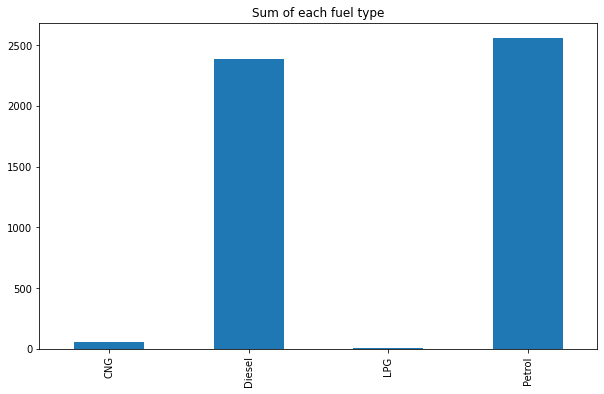

In [50]:
# Bar chart for sum of each fuel_type_cols 
plt.figure(figsize=(10,6))
df[fuel_type_cols].sum().plot(kind='bar')
plt.title('Sum of each fuel type')
plt.show()

As we can see, cars running on `Diesel` or `Petrol` fuel are **significantly larger** in number than cars running on `CNG` or `LPG`. So in the model, the accuracy will be higher in these types.

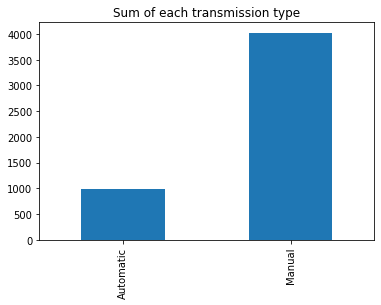

In [51]:
# Bar chart for sum of each transmission_cols
plt.figure()
df[transmission_cols].sum().plot(kind='bar')
plt.title('Sum of each transmission type')
plt.show()

The majority of cars in the data are `Manual` cars, meaning the data was collected a long time ago. The predicted price was only correct at that time **(5 years ago)**.

 If we want to predict current prices, adjusting for inflation is necessary.

### Box plot

In [52]:
df.shape

(5011, 59)

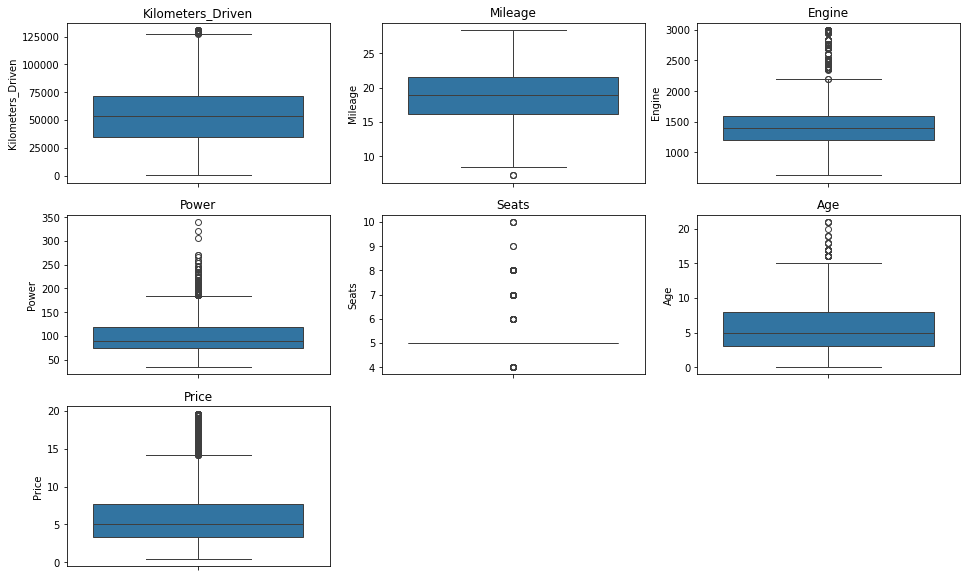

In [53]:
# Box plot for numerical columns
plt.figure(figsize=(16,10))
for i,col in enumerate(_numerical_cols):
    plt.subplot(3,3,i+1)
    sns.boxplot(df[col])
    plt.title(col)
plt.show()

In [54]:
# Q1, Q3 of price
Q1 = df["Price"].quantile(0.25)
Q3 = df["Price"].quantile(0.75)
print("The first quartile of Price is : ",Q1)
print("The third quartile of Price is : ",Q3)
print("So the 50% of Price is between {} and {}".format(Q1,Q3))

The first quartile of Price is :  3.3
The third quartile of Price is :  7.655
So the 50% of Price is between 3.3 and 7.655


### Correlation heatmap

<ipython-input-55-db838f6b6961>:4: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  sns.heatmap(df[numerical_cols].corr(),annot=True)


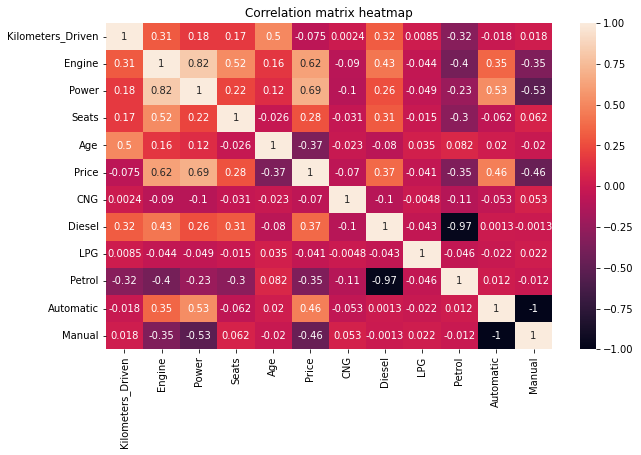

In [55]:
# Correlation matrix heatmap
numerical_cols = _numerical_cols + fuel_type_cols + transmission_cols
plt.figure(figsize=(10,6))
sns.heatmap(df[numerical_cols].corr(),annot=True)
plt.title('Correlation matrix heatmap')
plt.show()


The 3 factures that most impact on the old car price are `Power` (0.69), `Engine` (0.62), and `Tranmission` (0.46).

#### Histogram

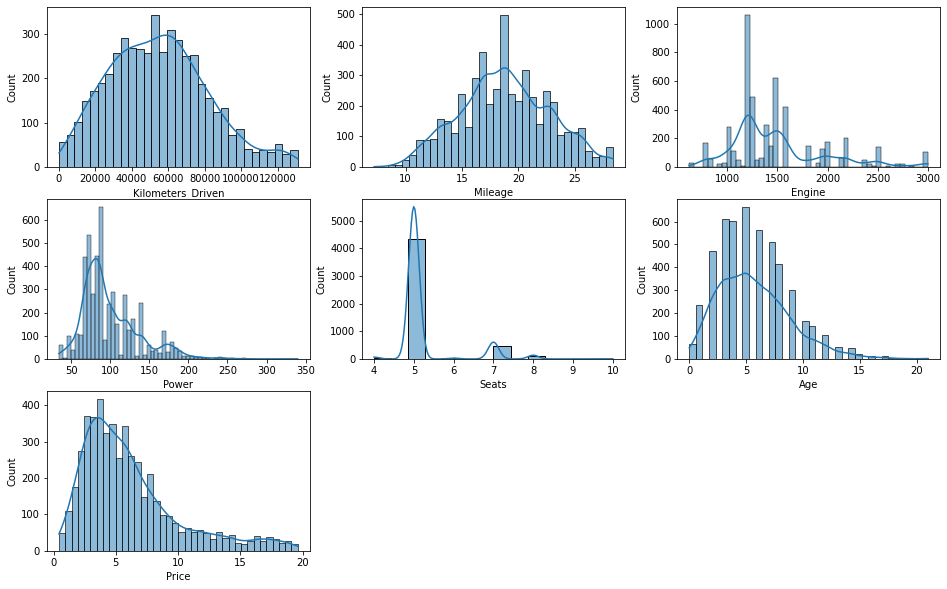

In [56]:
# Histogram for numerical columns
plt.figure(figsize=(16,10))
for i,col in enumerate(_numerical_cols):
    plt.subplot(3,3,i+1)
    sns.histplot(df[col],kde=True)
plt.show()

Most of the car has **5 Seats**.

The Age of the cars is almost in the range around [4,6] so the year is **2013 to 2015**